In [1]:
import torch

from rqvae.rqvae_data import get_data

df = get_data()

In [2]:
embs = torch.stack(df["embeddings"].tolist())

In [3]:
import json
from utils import DEVICE
from models.base import BaseModel

config = json.load(open("../configs/train/tiger_train_config.json"))

rqvae_train_config = json.load(open(config['rqvae_train_config_path']))
rq_vae_config = rqvae_train_config['model']
rq_vae_config['should_init_codebooks'] = False

rqvae_model = BaseModel.create_from_config(rq_vae_config).to(DEVICE)

rqvae_model.load_state_dict(torch.load(config['rqvae_checkpoint_path'], weights_only=True))
rqvae_model.eval()

ids = df.asin_numeric.tolist()

embs_dict = {"ids": torch.tensor(ids).to(DEVICE), "embeddings": embs.to(DEVICE)}

semantic_ids = list(rqvae_model.forward(embs_dict))

In [4]:
from rqvae.collisions import dedup

items_with_tuples = list(zip(df["asin"], df["title"].fillna("unknown"), semantic_ids))
items_with_tuples = dedup(items_with_tuples)

assert len(df) == len(set(item[-1] for item in items_with_tuples))

In [17]:
from rqvae.rqvae_data import search_similar_items


for i in range(5):
    sim = search_similar_items(items_with_tuples, (i,), 5)
    if len(sim) == 0:
        continue
    print(i)
    for asin, item, clust_tuple in sim:
        # if 'shampoo' in item.lower():
        print(f"{item=} {clust_tuple=}")

0
item='Revlon Beyond Natural Smoothing Primer, Clear, 0.85 Ounce' clust_tuple=(0, 33, 46, 141, 0)
item='Color Club Magic Attraction 843 Nail Polish' clust_tuple=(0, 228, 117, 102, 0)
item='Color Club Wild at Heart 871 Nail Polish' clust_tuple=(0, 228, 83, 106, 0)
1
item='Natural Beauty White / Brightening Essence Full Face Mask 10 Pcs' clust_tuple=(1, 210, 157, 13, 0)
item='OGX Conditioner, Nourishing Coconut Milk, 13oz' clust_tuple=(1, 50, 213, 95, 0)
item='BurnOut Eco-sensitive Zinc Oxide Sunscreen SPF 35 (3 oz)' clust_tuple=(1, 119, 46, 204, 0)
item='Kerastase Reflection Chroma Riche Luminous Softening Essence, 4.2 Ounce' clust_tuple=(1, 119, 3, 229, 0)
item='KINeSYS Performance Sunscreen, SPF 30, Spray, Mango Scent, 4-Ounce Bottles' clust_tuple=(1, 242, 54, 95, 0)
2
item='Pink Sugar by Aquolina for Women - 3.4 Ounce EDT Spray' clust_tuple=(2, 173, 246, 41, 0)
item='Guess By Parlux Fragrances For Men. Eau De Toilette Spray 2.5 Oz.' clust_tuple=(2, 104, 233, 139, 0)
item='Black Xs B

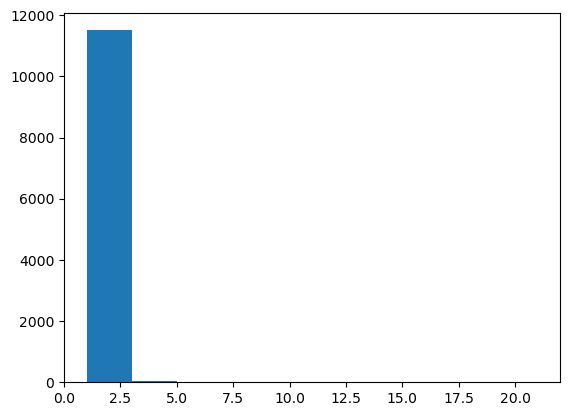

In [6]:
from collections import Counter
import matplotlib.pyplot as plt


plt.hist(Counter(item[-1][:-1] for item in items_with_tuples).values())
plt.show()

In [18]:
# # raw full ids
# full_duplicates = Counter(item[-1][:-1] for item in items_with_tuples).items()
# duplicated = [(semantic_id, amount) for (semantic_id, amount) in full_duplicates if amount > 1]
# duplicated

In [19]:
# collison counters - (how many item have same full semantic id): amount of such sets
vals = Counter(item[-1][:-1] for item in items_with_tuples).values()
Counter(vals)

Counter({1: 11195, 2: 316, 3: 44, 4: 12, 5: 3, 6: 3, 9: 2, 7: 2, 8: 1, 21: 1})

In [21]:
# dedup idxes
Counter(item[-1][4] for item in items_with_tuples)

Counter({0: 11579,
         1: 384,
         2: 68,
         3: 24,
         4: 12,
         5: 9,
         6: 6,
         7: 4,
         8: 3,
         10: 1,
         11: 1,
         17: 1,
         12: 1,
         15: 1,
         19: 1,
         13: 1,
         14: 1,
         9: 1,
         18: 1,
         16: 1,
         20: 1})

In [11]:
# from sklearn import preprocessing

# labels = df['asin']

# le = preprocessing.LabelEncoder()
# targets = le.fit_transform(labels)

# df['asin_numeric'] = targets

# torch.save(df, './all_data.pt')